## PSD multitaper

In [1]:
import os
import matplotlib.pyplot as plt

from scipy.signal import coherence, welch
from obspy import read_inventory, UTCDateTime, Stream

from andbro__read_sds import __read_sds

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
tbeg, tend = UTCDateTime("2023-09-25 11:00"), UTCDateTime("2023-09-25 12:00")

unit = "Pa"

In [4]:
path = root_path+"bay200/mseed_online/archive/"

st1 = __read_sds(path, "BW.FFBI..BDO", tbeg-1, tend+1)

# st1 = st1.resample(20.0)

# st1.trim(tbeg, tend)


path = archive_path+"romy_archive"

st2 = __read_sds(path, "BW.ROMY.10.BJZ", tbeg-1, tend+1)

inv2 = read_inventory(root_path+"Documents/ROMY/stationxml_ringlaser/dataless.seed.BW_ROMY")

# st2.trim(tbeg, tend)

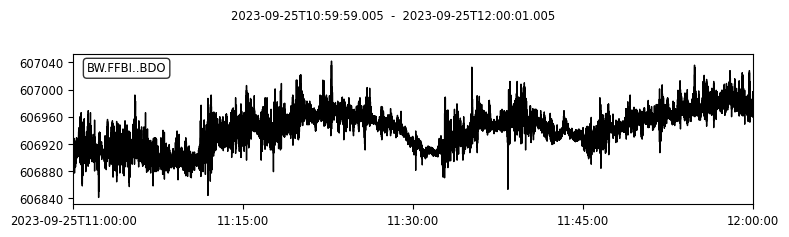

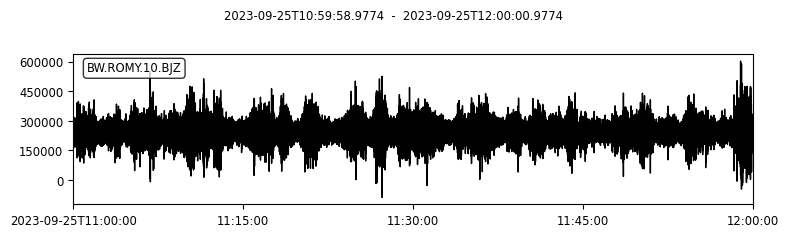

In [5]:
st1.plot();
st2.plot();

In [6]:
## conversion to Pa or hPa
for _st in [st1, st2]:

    if "O" in _st[0].stats.channel:

        if unit == "Pa":
            for tr in _st:
                tr.data = tr.data /1 /6.28099e5 /1e-5   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 1 mV/hPa
                # tr.data = tr.data /1.543 /6.28099e5 /1e-5   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 1 mV/hPa
        elif unit == "hPa":
            for tr in _st:
                tr.data = tr.data /1.543 /6.28099e5 /1e-3   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 1 mV/hPa
    if "F" in _st[0].stats.channel:

        for tr in _st:
            tr.data = tr.data /1.0 /6.28099e5 /0.02  # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity_mb2005=0.02 VPa

    if "J" in _st[0].stats.channel:
        _st = _st.remove_sensitivity(inv2)
        _st = _st.detrend("demean")

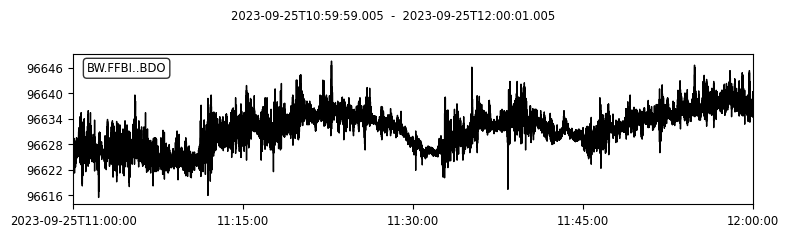

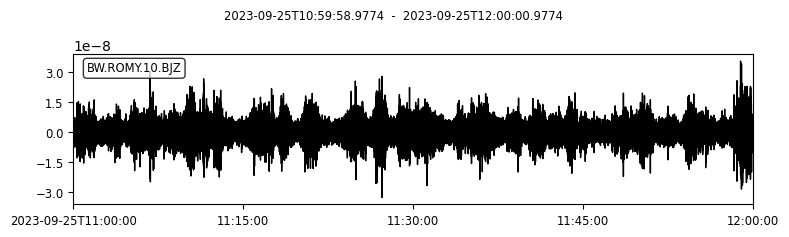

In [7]:
st1.plot();
st2.plot();

In [8]:
st1, st2

(1 Trace(s) in Stream:
BW.FFBI..BDO | 2023-09-25T10:59:59.005000Z - 2023-09-25T12:00:01.005000Z | 40.0 Hz, 144081 samples,
 1 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2023-09-25T10:59:58.977400Z - 2023-09-25T12:00:00.977400Z | 20.0 Hz, 72041 samples)

In [18]:
st = Stream()
st += st1.copy()
st += st2.copy()

st.resample(20.0, no_filter=False)
st.trim(tbeg, tend, nearest_sample=False)
# st.detrend("demean")


2 Trace(s) in Stream:
BW.FFBI..BDO   | 2023-09-25T11:00:00.005000Z - 2023-09-25T11:59:59.955000Z | 20.0 Hz, 72000 samples
BW.ROMY.10.BJZ | 2023-09-25T11:00:00.027400Z - 2023-09-25T11:59:59.977400Z | 20.0 Hz, 72000 samples

## Coherence

In [20]:
_N = len(st1[0].data)
df = st[0].stats.sampling_rate

t_seg = 1800
n_seg = int(df*t_seg) if int(df*t_seg) < _N else _N
n_over = int(0.9*n_seg)

ff_coh, coh = coherence(st.select(station="FFBI")[0].data,
                        st.select(station="ROMY")[0].data,
                        fs=df, window='hann', nperseg=n_seg, noverlap=n_over
                       )


In [47]:
def __multitaper_psd_cohe(arr1, arr2, dt, n_win=5, time_bandwidth=3.5):

    import multitaper as mt
    import multitaper.utils as utils

    out = {}

    ## Compute multitaper PSDs
    Psd1 = mt.MTSpec(arr1, nw=time_bandwidth, kspec=n_win, dt=dt, iadapt=2)
    Psd2 = mt.MTSpec(arr2, nw=time_bandwidth, kspec=n_win, dt=dt, iadapt=2)

    ## extract the frequencies and PSDs
    _f1, _psd1 = Psd1.rspec()
    out['f1'], out['psd1'] = _f1.reshape(_f1.size), _psd1.reshape(_psd1.size)

    _f2, _psd2 = Psd2.rspec()
    out['f2'], out['psd2'] = _f2.reshape(_f2.size), _psd2.reshape(_psd2.size)

    ## cross-correlation, coherence, deconvolution
    P12 = mt.MTCross(Psd1, Psd2, wl=0.001)
    N = P12.freq.size
    out['fcoh'], out['coherence'] = P12.freq[:,0][:N//2], P12.cohe[:,0][:N//2]

    return out

In [48]:
out = __multitaper_psd_cohe(st.select(station="FFBI")[0].data, st.select(station="ROMY")[0].data, 1/df, n_win=5, time_bandwidth=3.5)

In [49]:
ff_mt_coh, mt_coh = out['fcoh'], out['coherence']

## With Multitaper

In [38]:
def __multitaper_psd(arr, dt, n_win=5, time_bandwidth=3.5):

    import multitaper as mt

    out_psd = mt.MTSpec(arr, nw=time_bandwidth, kspec=n_win, dt=dt, iadapt=2)

    _f, _psd = out_psd.rspec()

    f = _f.reshape(_f.size)
    psd = _psd.reshape(_psd.size)

    ## 95% confidence interval
    # _psd95 = out_psd.jackspec()
    # psd95_lower, psd95_upper = psd95[::2, 0], psd95[::2, 1]

    return f, psd

In [39]:
_tr = st.select(station="ROMY")[0]

ff_romy, psd_romy = __multitaper_psd(_tr.data, _tr.stats.delta, n_win=6)

ff_romy2, psd_romy2 = welch(
                            st2.select(station="ROMY")[0].data,
                            fs=df, window='hann', nperseg=n_seg, noverlap=n_over,
                            return_onesided=True, scaling="density", average="mean",
                           )


_tr = st.select(station="FFBI")[0]

ff_ffbi, psd_ffbi = __multitaper_psd(_tr.data, _tr.stats.delta, n_win=6)

ff_ffbi2, psd_ffbi2 = welch(
                            st1.select(station="FFBI")[0].data,
                            fs=df, window='hann', nperseg=n_seg, noverlap=n_over,
                            return_onesided=True, scaling="density", average="mean",
                           )


In [40]:
from functions.get_fband_average import __get_fband_average

In [41]:
out = __get_fband_average(ff_coh, coh, 12, 'median')

coh_avg = out['psd_means']
ff_coh_avg = out['fcenter']

## Plotting

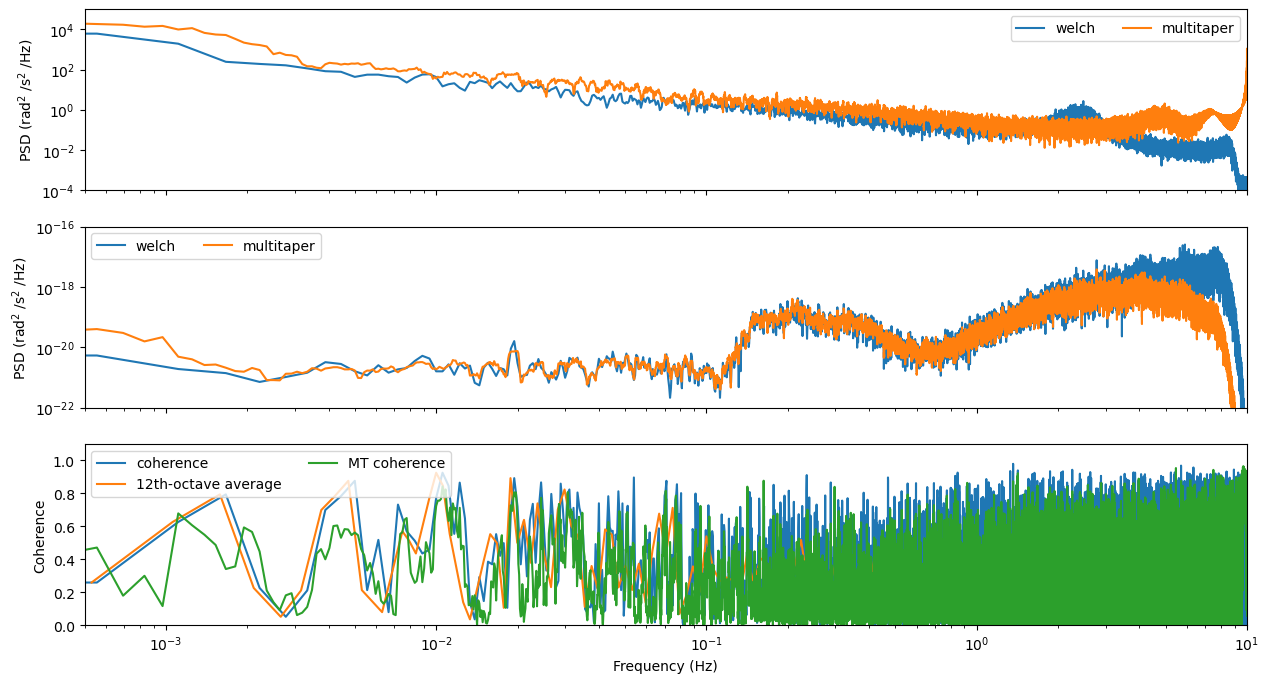

In [50]:
def __makeplot():

    fig, ax = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

    ax[0].loglog(ff_ffbi2, psd_ffbi2, label="welch")
    ax[0].loglog(ff_ffbi, psd_ffbi, label="multitaper")

    ax[1].loglog(ff_romy2, psd_romy2, label="welch")
    ax[1].loglog(ff_romy, psd_romy, label="multitaper")

    ax[2].semilogx(ff_coh, coh, label="coherence")
    ax[2].semilogx(ff_coh_avg, coh_avg, label="12th-octave average")
    ax[2].semilogx(ff_mt_coh, mt_coh, label="MT coherence")

    for i in range(3):
        ax[i].set_xlim(5e-4, 1e1)
        ax[i].legend(ncol=2)

    ax[0].set_ylim(1e-4, 1e5)
    ax[1].set_ylim(1e-22, 1e-16)
    ax[2].set_ylim(0, 1.1)

    ax[0].set_ylabel("PSD (rad$^2$ /s$^2$ /Hz)")
    ax[1].set_ylabel("PSD (rad$^2$ /s$^2$ /Hz)")
    ax[2].set_ylabel("Coherence")

    ax[2].set_xlabel("Frequency (Hz)")

    plt.show();

__makeplot()